<a href="https://colab.research.google.com/github/hukongyi/d2l_Colab/blob/main/08_linear_regression/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l > /dev/null
!pip install matplotlib > /dev/null
!pip install matplotlib_inline > /dev/null

# 线性回归的从零实现

In [2]:
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.__version__

'1.12.1+cu113'

In [4]:
def synthetic_data(w, b, num_examples):
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w)+b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape(-1, 1)


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

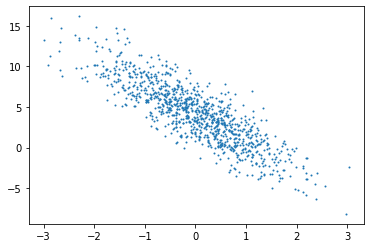

In [5]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indice = torch.tensor(
            indices[i: min(i+batch_size, num_examples)])
        yield features[batch_indice], labels[batch_indice]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0825, -1.6055],
        [ 1.2735,  0.9071],
        [ 0.6589,  0.4092],
        [ 0.8729,  1.4214],
        [ 0.3959,  0.3264],
        [ 1.3727, -0.0568],
        [-0.9587,  0.0051],
        [ 1.1491,  0.5455],
        [-1.9138, -2.6757],
        [-0.7797,  0.3882]]) 
 tensor([[9.8200],
        [3.6563],
        [4.1284],
        [1.1111],
        [3.8796],
        [7.1538],
        [2.2526],
        [4.6444],
        [9.4937],
        [1.3200]])


In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [10]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):0.5f}')

epoch 1, loss 0.04781
epoch 2, loss 0.00021
epoch 3, loss 0.00006


In [12]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0002, -0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0002], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [13]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [14]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [16]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.1200,  0.9155],
         [ 0.9365,  0.0828],
         [-0.1828,  0.8094],
         [ 0.7796, -0.1413],
         [-2.1452,  0.6327],
         [ 0.5719,  0.2098],
         [-0.3947, -1.4894],
         [ 0.4870, -0.4015],
         [-0.1696,  0.3491],
         [-1.1494, -0.3730]]), tensor([[ 0.8545],
         [ 5.8009],
         [ 1.0874],
         [ 6.2205],
         [-2.2438],
         [ 4.6210],
         [ 8.4752],
         [ 6.5307],
         [ 2.6843],
         [ 3.1803]])]

In [17]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [18]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [19]:
loss = nn.MSELoss()

In [20]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000232
epoch 2, loss 0.000100
epoch 3, loss 0.000100
